In [46]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from superfv.euler_solver import EulerSolver

In [47]:
gamma = 1.4
rho0 = 1
cs0 = 1
P0 = 1 / gamma
L = 1
k = 2 * np.pi / L
omega = cs0 * k
A = 1e-5


def nonlinear_sound_wave(array_slicer, x, y, z, t):
    _slc = array_slicer

    def vp(x, t):
        return A * np.sin(k * x - omega * t) + A**2 * ((gamma + 1) / 4) * (
            omega * t / cs0
        ) * np.cos(2 * (k * x - omega * t))

    out = np.zeros((5, *x.shape))
    out[_slc("rho")] = rho0 + rho0 * vp(x, 0) / cs0  # only valid for t=0
    out[_slc("vx")] = vp(x, t)
    out[_slc("P")] = P0 + gamma * P0 * vp(x, 0) / cs0  # only valid for t=0

    return out


N = 512
p = 3

solver = EulerSolver(
    ic=partial(nonlinear_sound_wave, t=0),
    gamma=gamma,
    nx=N,
    p=p,
    CFL=0.8,
    riemann_solver="llf",
    flux_recipe=3,
    lazy_primitives=False,
    ZS=True,
    adaptive_timestepping=False,
    SED=True,
)
solver.run(L / cs0)

100%|██████████| 1.0/1.0 [00:04]                  


Text(0.5, 0, 'x')

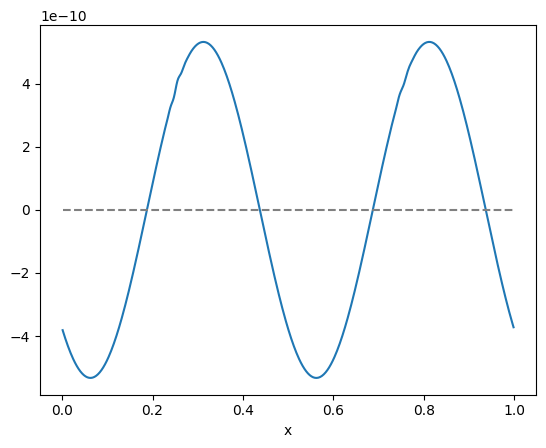

In [50]:
_slc = solver.array_slicer
u = solver.snapshots[-1]["u"]
ucc = solver.interpolate_cell_centers(
    solver.apply_bc(u, -(-p // 2)),
    interpolation_scheme=solver.interpolation_scheme,
    p=p,
)
wcc = solver.primitives_from_conservatives(ucc)

vx_numerical = wcc[_slc("vx")].flatten()
vx_exact = nonlinear_sound_wave(_slc, solver.x, None, None, L / cs0)[
    _slc("vx")
].flatten()
error = vx_numerical - vx_exact
plt.plot(solver.x, error)
plt.plot(solver.x, 0 * solver.x, color="grey", linestyle="--")
plt.xlabel("x")

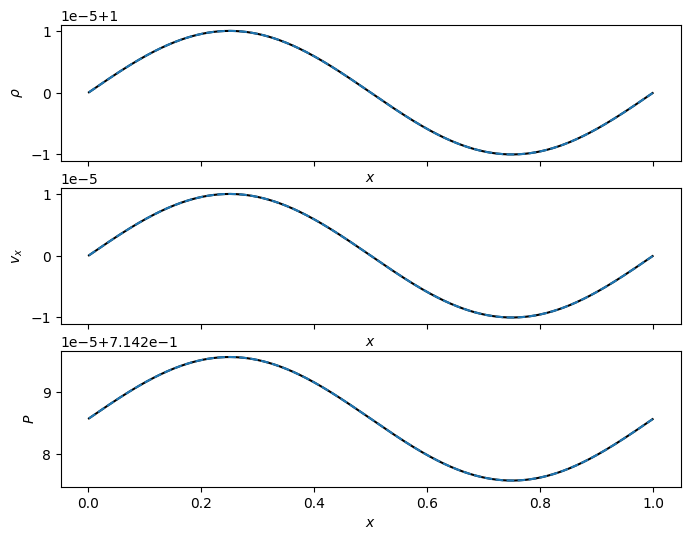

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axs[0].set_ylabel(r"$\rho$")
solver.plot_1d_slice(axs[0], "rho", array="w", x=None, t=0, color="k", label="t=0")
solver.plot_1d_slice(axs[0], "rho", array="w", x=None, linestyle="--", label="t=1")

axs[1].set_ylabel(r"$v_x$")
solver.plot_1d_slice(axs[1], "vx", array="w", x=None, t=0, color="k", label="t=0")
solver.plot_1d_slice(axs[1], "vx", array="w", x=None, linestyle="--", label="t=1")

axs[2].set_ylabel(r"$P$")
solver.plot_1d_slice(axs[2], "P", array="w", x=None, t=0, color="k", label="t=0")
solver.plot_1d_slice(axs[2], "P", array="w", x=None, linestyle="--", label="t=1")